In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from utils_datetime import *
from utils_filter import *

In [2]:
# seeing how size of tstm area changes over time
data_location = 'data'
mod_string = 'labelled'

skill = False
if skill:
    skill_str = 'skill_'
else:
    skill_str = ''

type_str = 'binary_' # '' (outlook vs pph), 'binary_' (outlook vs truth), or 'optimal_' (pph vs truth)

ah = '_no_ah' # or '_no_ah' ''

outlooks = gp.read_file(data_location + '/outlooks/' + mod_string + '_outlooks.shp', engine="pyogrio")

C:\Users\miles\AppData\Local\Temp\ipykernel_20484\1242978410.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  outlooks['area'] = outlooks.geometry.area


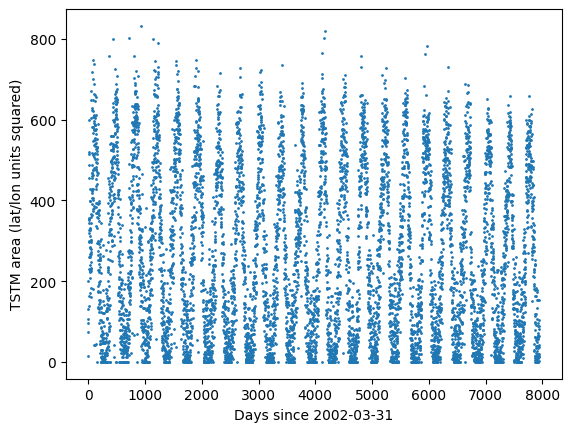

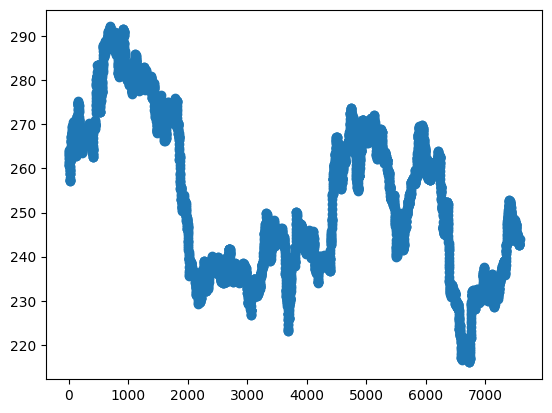

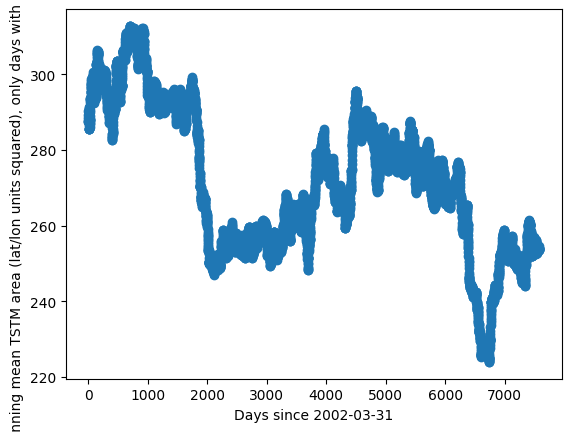

In [223]:
# all days
outlooks = outlooks[(outlooks['DAY'] == 1) & (outlooks['THRESHOLD'] == 'TSTM') & (outlooks['DATE'] >= '200203310000')]

# only MDT or HIGH days
#outlooks = outlooks[(outlooks['DAY'] == 1) & (outlooks['THRESHOLD'] == 'TSTM') & (outlooks['DATE'] >= '200203310000') & ((outlooks['MAX_CAT'] == 'MDT') | (outlooks['MAX_CAT'] == 'HIGH'))]
outlooks['area'] = outlooks.geometry.area

nonzero_tstm_area = outlooks['area']

outlooks['DATE'] = outlooks['DATE'].astype('datetime64[ns]')
outlooks = outlooks.drop_duplicates(subset='ISSUE', keep='first')

all_dates = pd.date_range(start=outlooks['DATE'].min(), end=outlooks['DATE'].max())

# Reindex DataFrame to include all dates and fill missing areas with 0
df = outlooks.set_index('DATE').reindex(all_dates).fillna({'area': 0}).reset_index()
df.rename(columns={'index': 'DATE'}, inplace=True)

tstm_areas = df['area']

plt.scatter(range(len(tstm_areas)), tstm_areas, s = 1)
plt.ylabel('TSTM area (lat/lon units squared)')
plt.xlabel('Days since 2002-03-31')
plt.show()
plt.clf()


window_size = 365
running_mean = np.convolve(tstm_areas, np.ones(window_size)/window_size, mode='valid')
plt.scatter(range(len(running_mean)), running_mean)
plt.show()
plt.clf()
plt.ylabel('1 year running mean TSTM area (lat/lon units squared)')
plt.xlabel('Days since 2002-03-31')


nonzero_running_mean = [
    np.mean(tstm_areas[i:i+window_size][tstm_areas[i:i+window_size] > 0]) 
    if np.any(tstm_areas[i:i+window_size] > 0) 
    else 0
    for i in range(len(tstm_areas) - window_size + 1)
]

plt.ylabel('1 year running mean TSTM area (lat/lon units squared), only days with nonzero values')
plt.xlabel('Days since 2002-03-31')
plt.scatter(range(len(nonzero_running_mean)), nonzero_running_mean)

In [3]:
contingencies = xr.load_dataset('data/contingency/' + type_str + 'contingency_regions.nc')

In [5]:
a = contingencies.sel(time = '201905200000', hazard = 'Wind', region = 'CONUS').a.values
b = contingencies.sel(time = '201905200000', hazard = 'Wind', region = 'CONUS').b.values
c = contingencies.sel(time = '201905200000', hazard = 'Wind', region = 'CONUS').c.values
d = contingencies.sel(time = '201905200000', hazard = 'Wind', region = 'CONUS').d.values
a, b, c, d, a + b, c + d, a + c, b + d, a +b + c + d

(array(8.2),
 array(23.2),
 array(23.8),
 array(1269.8),
 31.400000000000002,
 1293.5999999999997,
 31.999999999999996,
 1292.9999999999998,
 1324.9999999999998)

In [226]:
if skill:
    optimal_contingencies = xr.load_dataset('data/contingency/optimal_contingency_regions.nc')

In [227]:
pph = xr.load_dataset('data/pph/labelled_pph.nc')

In [228]:
missing_dates = ['200204250000', '200208300000', '200304150000', '200304160000', '200306250000', '200307270000', '200307280000', '200312280000', '200404140000', '200408090000', '200905280000', '201105210000', '202005240000']
pph = pph.sel(time=~pph['time'].isin(missing_dates))
contingencies = contingencies.sel(time=~contingencies['time'].isin(missing_dates))

day3_dates = pph['time'][pph['time'] >= '200203300000']
contingencies = contingencies.sel(time = day3_dates, region = 'CONUS')
pph = pph.sel(time = day3_dates)
mdt_dates = pph['time'][pph['MAX_CAT'].isin(['MDT', 'HIGH'])]
mdt_contingencies = contingencies.sel(time = mdt_dates)

high_dates = pph['time'][pph['MAX_CAT'].isin(['HIGH'])]
high_contingencies = contingencies.sel(time = high_dates)

if skill:
    optimal_contingencies = optimal_contingencies.sel(time=~optimal_contingencies['time'].isin(missing_dates))
    optimal_contingencies = optimal_contingencies.sel(time = day3_dates, region = 'CONUS')
    optimal_mdt_contingencies = optimal_contingencies.sel(time = mdt_dates)
    optimal_high_contingencies = optimal_contingencies.sel(time = high_dates)
else: 
    optimal_contingencies = None
    optimal_mdt_contingencies = None
    optimal_high_contingencies = None

In [229]:
# Adapted from https://gist.github.com/djgagne/64516e3ea268ec31fb34

def performance_diagram(pods, fars, obj_labels, colors, markers, filename = '', save = False, show = True, figsize=(9, 8), points = True, xlabel="Success Ratio (1-FAR)",
                        ylabel="Probability of Detection", ticks=np.arange(0, .6, 0.1), dpi=300, csi_cmap="Blues",
                        csi_label="Critical Success Index", title="Performance Diagram",
                        legend_params=dict(loc=4, fontsize=12, framealpha=1, frameon=True),
                        ax = None):
    """
    Draws a performance diagram from a set of POD lists and FAR lists.
    :param pods: list or array of POD arrays.
    :param fars: list or array of FAR arrays.
    :param obj_labels: list or array of labels describing each DistributedROC object.
    :param colors: list of color strings
    :param markers: list of markers.
    :param filename: output filename.
    :param save: whether the figure will be saved
    :param show: whether the figure will be shown in the console
    :param figsize: tuple with size of the figure in inches.
    :param points: True if the plotted points should be separate, otherwise connected
    :param xlabel: Label for the x-axis
    :param ylabel: Label for the y-axis
    :param ticks: Array of ticks used for x and y axes
    :param dpi: DPI of the output image
    :param csi_cmap: Colormap used for the CSI contours
    :param csi_label: Label for the CSI colorbar
    :param ax: Axis object to plot the diagram
    :return:
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        own_fig = True
    else:
        fig = ax.figure  # Get figure from existing axis
        own_fig = False

    if skill:
        grid_ticks = np.arange(0, 1.01, 0.01)
        ticks=np.arange(0, 1.01, 0.1)
    else:
        grid_ticks = np.arange(0, .51, 0.01)
    sr_g, pod_g = np.meshgrid(grid_ticks, grid_ticks)
    bias = pod_g / sr_g
    csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)

    if skill:
        csi_contour = ax.contourf(sr_g, pod_g, csi, np.arange(.05, 1, 0.05), extend="max", cmap=csi_cmap)
    else:
        csi_contour = ax.contourf(sr_g, pod_g, csi, np.arange(.025, .325, 0.025), extend="max", cmap=csi_cmap)
    b_contour = ax.contour(sr_g, pod_g, bias, [.25, 0.5, 1, 2, 4], colors="k", linestyles="dashed")
    ax.clabel(b_contour, fmt="%1.2f", manual=[(0.1, 0.45), (0.2, 0.45), (0.35, 0.35), (.45, .2), (.45, .1)])
    for r, (pod, far) in enumerate(zip(pods, fars)):
        if points:
            ax.scatter(1 - far, pod, marker=markers[r], color=colors[r], label=obj_labels[r], s = 100)
        else:
            ax.plot(1 - far, pod, marker=markers[r], color=colors[r], label=obj_labels[r], markersize = 5, linewidth = 1)
            shift0 = .03
            shift1 = .03
            if r == 3:
                shift1 = 0
            ax.annotate('2002', xy = (1-far[1], pod[1]), xytext=(1-far[1]-shift1, pod[1]+shift0), arrowprops=dict(arrowstyle="->"))
            ax.annotate('2023', xy = (1-far[-1], pod[-1]), xytext=(1-far[-1]+shift0, pod[-1]-shift1), arrowprops=dict(arrowstyle="->"))
    
    cbar = fig.colorbar(csi_contour)
    cbar.set_label(csi_label, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_title(title, fontsize=14, fontweight="bold")
    if skill:
        ax.text(0.48,0.52,"Frequency Bias",fontdict=dict(fontsize=14, rotation=48))
    else:
        ax.text(0.24,0.26,"Frequency Bias",fontdict=dict(fontsize=14, rotation=48))

    if len(obj_labels) > 8:
        legend_params=dict(loc='center left', bbox_to_anchor=(1.3, 0.5), fontsize=12, framealpha=1, frameon=True)
    
    ax.legend(**legend_params)

    if save:
        plt.savefig(filename, dpi=dpi, bbox_inches="tight")
    if show and own_fig:
        plt.show()

In [230]:
# Adapted from https://gist.github.com/djgagne/64516e3ea268ec31fb34

def QROC(q1s, q0s, obj_labels, colors, markers, filename = '', save = False, show = True, figsize=(9, 8), points = True, xlabel="Q0",
                        ylabel="Q1", ticks=np.arange(0, .6, 0.1), dpi=300, csi_cmap="Blues",
                         title="QROC",
                        legend_params=dict(loc=4, fontsize=12, framealpha=1, frameon=True)):
    """
    Draws a performance diagram from a set of POD lists and FAR lists.
    :param q1s: list or array of Q1 arrays.
    :param q0s: list or array of Q0 arrays.
    :param obj_labels: list or array of labels describing each DistributedROC object.
    :param colors: list of color strings
    :param markers: list of markers.
    :param filename: output filename.
    :param save: whether the figure will be saved
    :param show: whether the figure will be shown in the console
    :param figsize: tuple with size of the figure in inches.
    :param points: True if the plotted points should be separate, otherwise connected
    :param xlabel: Label for the x-axis
    :param ylabel: Label for the y-axis
    :param ticks: Array of ticks used for x and y axes
    :param dpi: DPI of the output image
    :param csi_cmap: Colormap used for the CSI contours
    :param csi_label: Label for the CSI colorbar
    :return:
    """
    plt.figure(figsize=figsize)
    grid_ticks = np.arange(0, .51, 0.01)
    sr_g, pod_g = np.meshgrid(grid_ticks, grid_ticks)
    bias = pod_g / sr_g
    b_contour = plt.contour(sr_g, pod_g, bias, [.25, 0.5, 1, 2, 4], colors="k", linestyles="dashed")
    plt.clabel(b_contour, fmt="%1.2f", manual=[(0.1, 0.45), (0.2, 0.45), (0.35, 0.35), (.45, .2), (.45, .1)])
    for r, pod, far in zip(range(len(q1s)), q1s, q0s):
        if points:
            plt.scatter(far, pod, marker=markers[r], color=colors[r], label=obj_labels[r], s = 100)
        else:
            plt.plot(far, pod, marker=markers[r], color=colors[r], label=obj_labels[r], markersize = 5, linewidth = 1)
            shift0 = .03
            shift1 = .03
            if r == 3:
                shift1 = 0
            plt.annotate('2002', xy = (1-far[1], pod[1]), xytext=(1-far[1]-shift1, pod[1]+shift0), arrowprops=dict(arrowstyle="->"))
            plt.annotate('2023', xy = (1-far[-1], pod[-1]), xytext=(1-far[-1]+shift0, pod[-1]-shift1), arrowprops=dict(arrowstyle="->"))

    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(ticks)
    plt.yticks(ticks)
    plt.title(title, fontsize=14, fontweight="bold")
    plt.text(0.24,0.26,"Frequency Bias",fontdict=dict(fontsize=14, rotation=48))

    if len(obj_labels) > 8:
        legend_params=dict(loc='center left', bbox_to_anchor=(1.3, 0.5), fontsize=12, framealpha=1, frameon=True)
    
    plt.legend(**legend_params)

    if save:
        plt.savefig(filename, dpi=dpi, bbox_inches="tight")
    if show:
        plt.show()




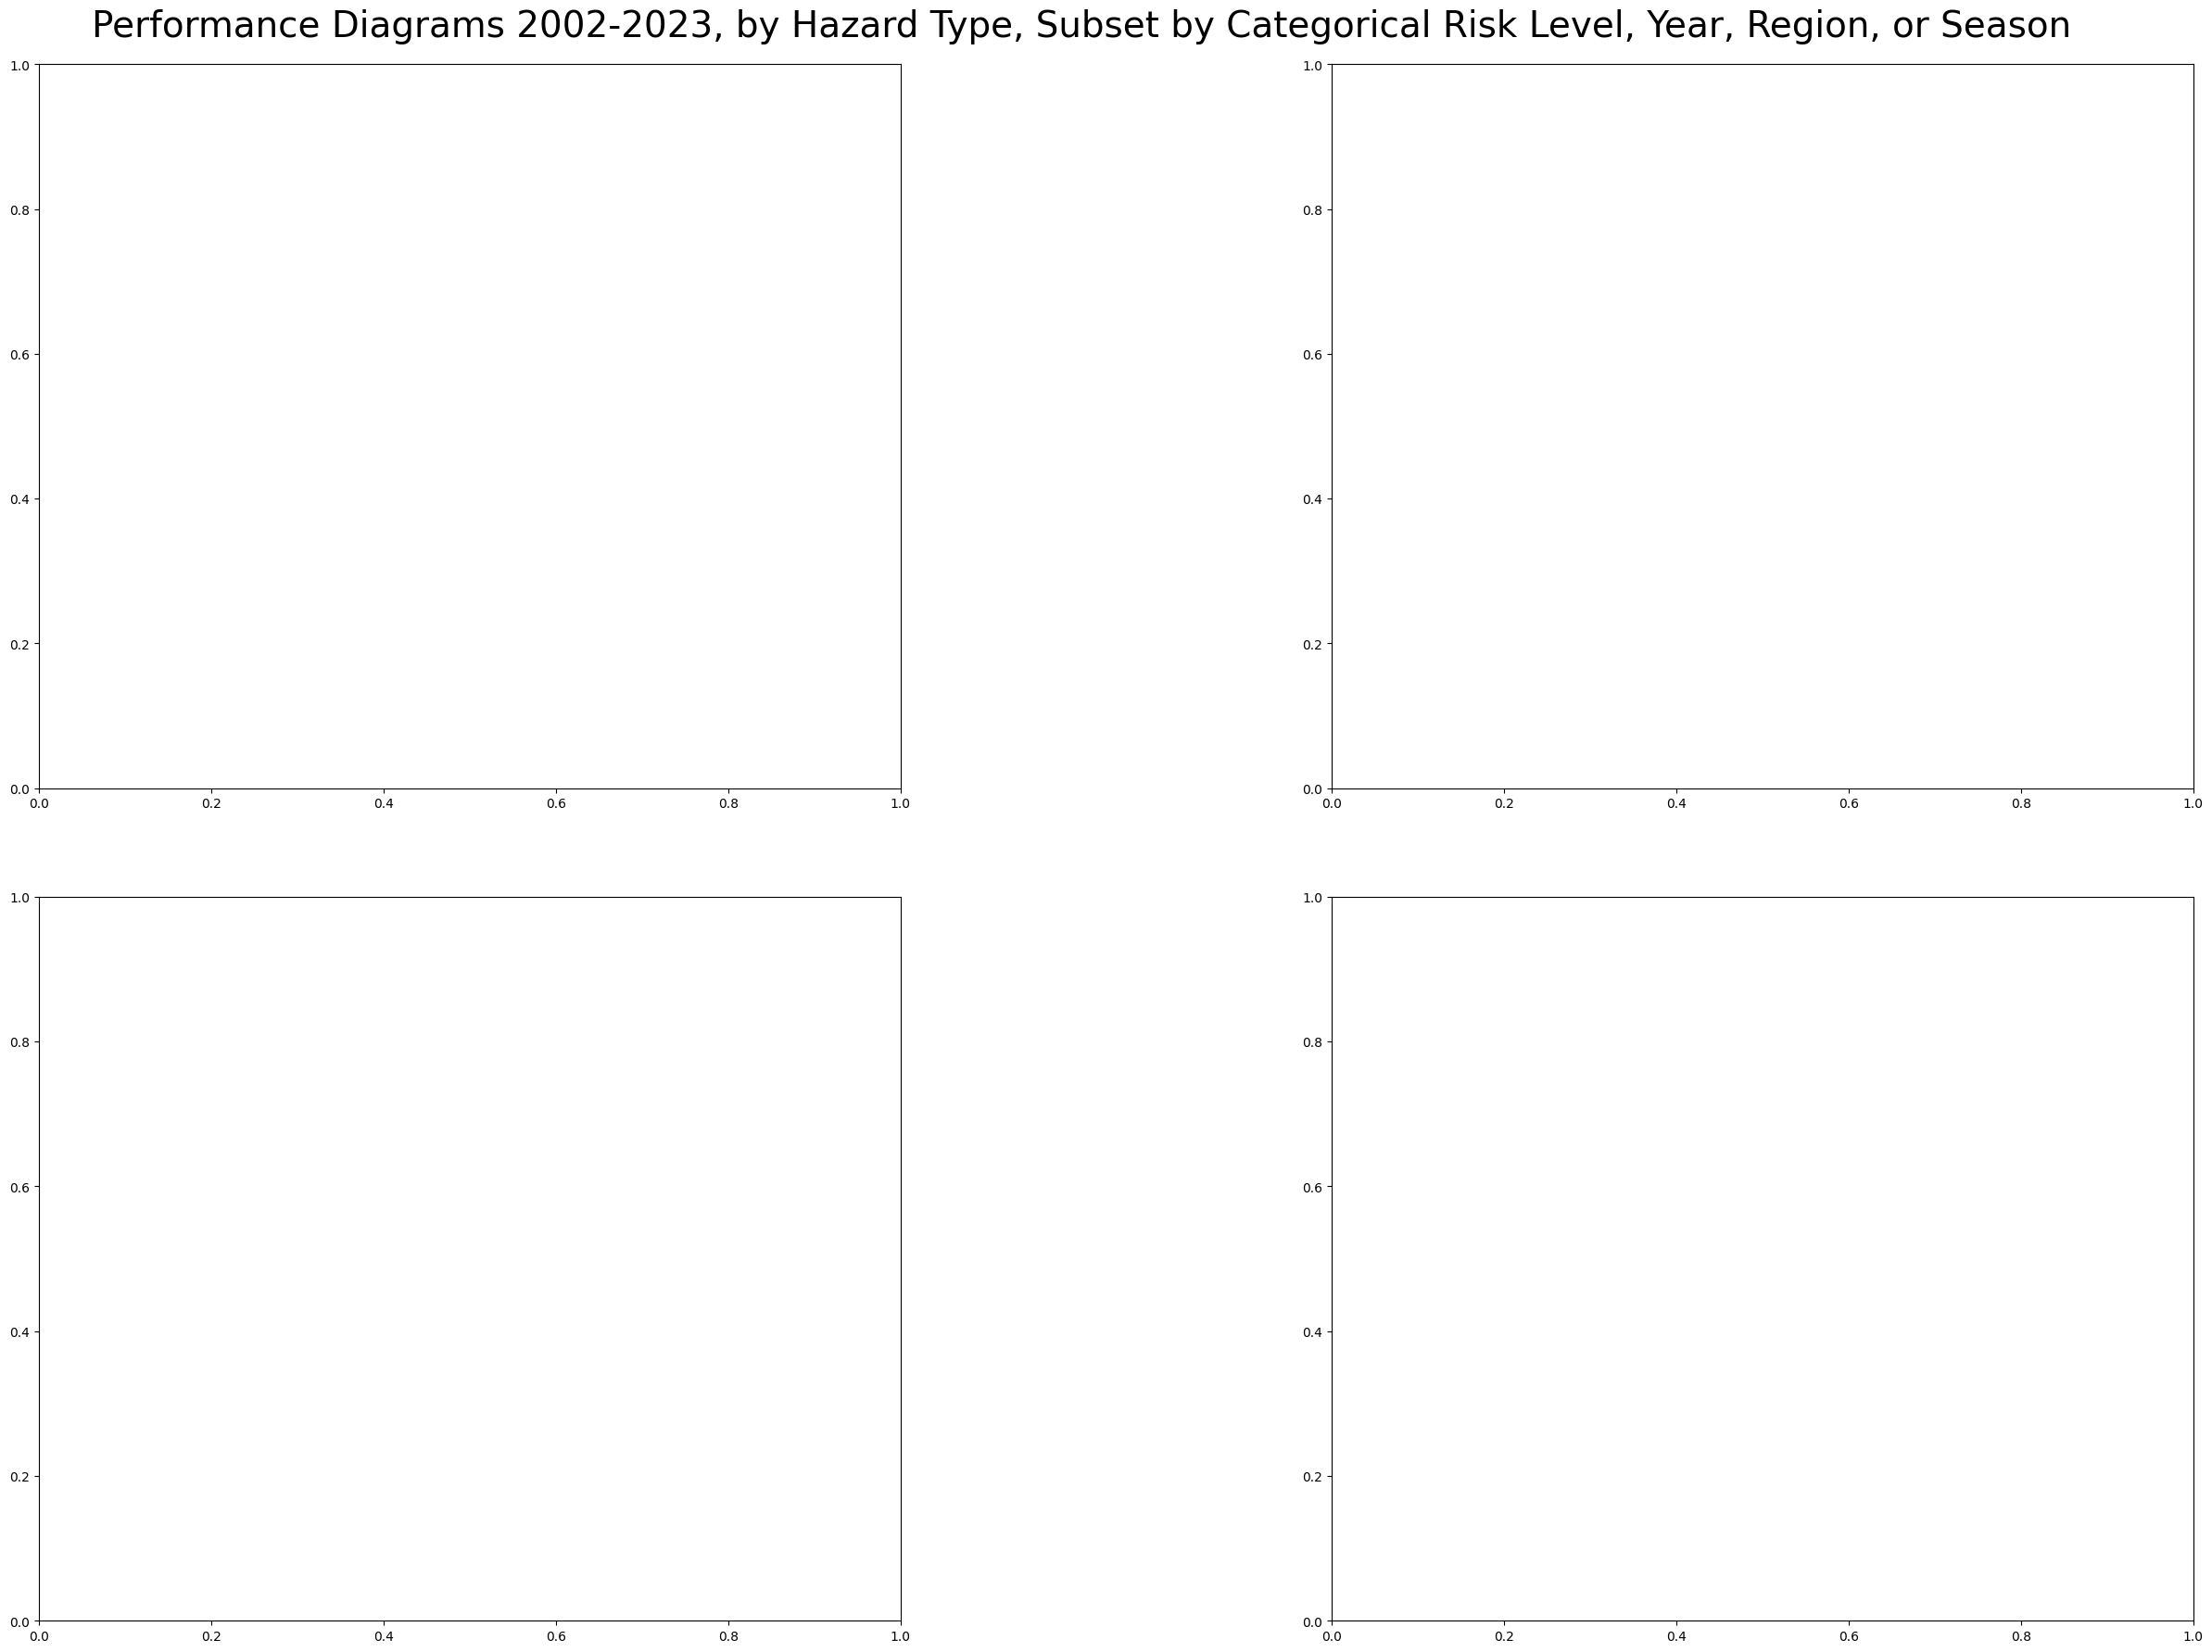

In [231]:
combined_figure = True # true if we want running these next cells to result in one figure with multiple pds, false keeps as separate figures
if combined_figure:
    fig, axes = plt.subplots(2, 2, figsize=(30, 20))
    fig.suptitle('Performance Diagrams 2002-2023, by Hazard Type, Subset by Categorical Risk Level, Year, Region, or Season', fontsize = 28)
    fig.subplots_adjust(hspace=0.15, wspace=.5, top = .95)

In [232]:
pods = []
fars = []
q1s = []
q0s = []
labels = []
colors = []
markers = []
if ah == '':
    hazard_types = ['All Hazard', 'Wind', 'Hail', 'Tornado']
else:
    hazard_types = ['Wind', 'Hail', 'Tornado']

color_dict = {
    'Wind': 'dodgerblue',
    'Hail': 'palegreen',
    'Tornado': 'lightcoral',
    'All Hazard': 'lightgray'
}

mdt_color_dict = {
    'Wind': 'navy',
    'Hail': 'darkgreen',
    'Tornado': 'maroon',
    'All Hazard': 'black'
}

color_dict = {
    'Wind': 'blue',
    'Hail': 'green',
    'Tornado': 'red',
    'All Hazard': 'black'
}

mdt_color_dict = {
    'Wind': 'blue',
    'Hail': 'green',
    'Tornado': 'red',
    'All Hazard': 'black'
}

for contingencies_dataset, optimal_contingencies_dataset, thresh in zip([contingencies, mdt_contingencies, high_contingencies], [optimal_contingencies, optimal_mdt_contingencies, optimal_high_contingencies], ['all', 'mdt', 'high']):
    for hazard in hazard_types:
        c = contingencies_dataset.sel(hazard = hazard)
        if skill:
            o = optimal_contingencies_dataset.sel(hazard = hazard)
            pods.append(np.array([c['a'].values.sum()/(c['a'].values.sum() + c['c'].values.sum())]) / np.array([o['a'].values.sum()/(o['a'].values.sum() + o['c'].values.sum())]))
            fars.append(1 - ((1 - np.array([c['b'].values.sum()/(c['a'].values.sum() + c['b'].values.sum())])) / (1 - np.array([o['b'].values.sum()/(o['a'].values.sum() + o['b'].values.sum())]))))
        else:
            pods.append(np.array([c['a'].values.sum()/(c['a'].values.sum() + c['c'].values.sum())]))
            fars.append(np.array([c['b'].values.sum()/(c['a'].values.sum() + c['b'].values.sum())]))
        expected = (c['a'].values.sum() + c['c'].values.sum())*(c['a'].values.sum() + c['b'].values.sum()) / (c['a'].values.sum() + c['b'].values.sum() + c['c'].values.sum() + c['d'].values.sum())
        q1s.append(np.array([(c['a'].values.sum() - expected)/(c['a'].values.sum() + c['c'].values.sum() - expected)]))
        q0s.append(np.array([(c['a'].values.sum() - expected)/(c['a'].values.sum() + c['b'].values.sum() - expected)]))

        if thresh == 'mdt':
            labels.append(hazard + ' (MDT+)')
            colors.append(mdt_color_dict[hazard])
            markers.append('s')
        elif thresh == 'high':
            labels.append(hazard + ' (HIGH)')
            colors.append(mdt_color_dict[hazard])
            markers.append('*')
        else:
            labels.append(hazard + ' (All Days)')
            colors.append(color_dict[hazard])
            markers.append('o')

        # No Skill
        #pods.append(np.array([(c['a'].values.sum() + c['c'].values.sum()) / (c['a'].values.sum() + c['b'].values.sum() + c['c'].values.sum() + c['d'].values.sum())]))
        #fars.append(np.array([1 - (c['a'].values.sum() + c['c'].values.sum()) / (c['a'].values.sum() + c['b'].values.sum() + c['c'].values.sum() + c['d'].values.sum())]))
        #if mdt:
        #    labels.append('_nolegend_')
        #    colors.append(mdt_color_dict[hazard])
        #    markers.append('.')
        #else:
        #    labels.append('_nolegend_')
        #    colors.append(color_dict[hazard])
        #   markers.append('.')
        
if combined_figure:
    performance_diagram(pods, fars, labels, colors, markers, title = "Risk Level", save = False, filename = None, ax = axes[0, 0])
else:
    performance_diagram(pods, fars, labels, colors, markers, title = "Performance Diagram by Hazard Type and Risk Level Days 2002-2023", save = True, filename = 'plots/results/' + skill_str + type_str + 'performacne_diagram_all_and_mdt' + ah + '.pdf')
    #QROC(q1s, q0s, labels, colors, markers, title = "QROC by Hazard Type and Risk Level Days 2002-2023", save = False)

C:\Users\miles\AppData\Local\Temp\ipykernel_20484\651609465.py:42: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_20484\651609465.py:42: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_20484\651609465.py:43: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


In [233]:
date_contingencies = contingencies.sel(time = '201905200000')
date_contingencies['pod'] = date_contingencies['a'] / (date_contingencies['a'] + date_contingencies['c'])
date_contingencies['far'] = date_contingencies['b'] / (date_contingencies['a'] + date_contingencies['b'])

if skill:
    optimal_date_contingencies = optimal_contingencies.sel(time = '201905200000')
    optimal_date_contingencies['pod'] = optimal_date_contingencies['a'] / (optimal_date_contingencies['a'] + optimal_date_contingencies['c'])
    optimal_date_contingencies['far'] = optimal_date_contingencies['b'] / (optimal_date_contingencies['a'] + optimal_date_contingencies['b'])


date_contingencies['csi'] = date_contingencies['a'] / (date_contingencies['a'] + date_contingencies['b'] + date_contingencies['c'])

date_contingencies['bias'] = (date_contingencies['a'] + date_contingencies['b']) / (date_contingencies['a'] + date_contingencies['c'])

date_contingencies['expected'] = ((date_contingencies['a'] + date_contingencies['b']) * (date_contingencies['a'] + date_contingencies['c'])) / (date_contingencies['a'] + date_contingencies['b'] + date_contingencies['c'] + date_contingencies['d'])
date_contingencies['q1'] = (date_contingencies['a'] - date_contingencies['expected']) / (date_contingencies['a'] + date_contingencies['c'] - date_contingencies['expected'])
date_contingencies['q0'] = (date_contingencies['a'] - date_contingencies['expected']) / (date_contingencies['a'] + date_contingencies['b'] - date_contingencies['expected'])

pods = []
fars = []
q1s = []
q0s = []

for hazard in hazard_types:
    if skill:
        pods.append(date_contingencies['pod'].sel(hazard = hazard) / optimal_date_contingencies['pod'].sel(hazard = hazard))
        fars.append(1 - ((1 - date_contingencies['far'].sel(hazard = hazard)) / (1 - optimal_date_contingencies['far'].sel(hazard = hazard))))
    else:
        pods.append(date_contingencies['pod'].sel(hazard = hazard))
        fars.append(date_contingencies['far'].sel(hazard = hazard))
    q1s.append(date_contingencies['q1'].sel(hazard = hazard))
    q0s.append(date_contingencies['q0'].sel(hazard = hazard))

if not combined_figure:
    performance_diagram(pods, fars, hazard_types, ['blue', 'green', 'red', 'black'], ['o', 'o', 'o', 'o'], points = True, show = False, save = True, title = 'May 20, 2019 Performance Diagram', filename='plots/results/' + skill_str + type_str + 'performance_201905200000' + ah + '.pdf')
    #QROC(q1s, q0s, labels, colors, markers, title = "May 20, 2019 QROC", save = False)

In [234]:
contingencies['time'] = pd.to_datetime(contingencies['time'].values, format='%Y%m%d0000')
year_contingencies = contingencies.rolling(time=365, center=True).sum()
season_contingencies = contingencies.rolling(time=91, center=True).sum()

if skill:
    optimal_contingencies['time'] = pd.to_datetime(optimal_contingencies['time'].values, format='%Y%m%d0000')
    optimal_year_contingencies = optimal_contingencies.rolling(time=365, center=True).sum()
    optimal_season_contingencies = optimal_contingencies.rolling(time=91, center=True).sum()

contingencies['pod'] = contingencies['a'] / (contingencies['a'] + contingencies['c'])
year_contingencies['pod'] = year_contingencies['a'] / (year_contingencies['a'] + year_contingencies['c'])
season_contingencies['pod'] = season_contingencies['a'] / (season_contingencies['a'] + season_contingencies['c'])

contingencies['far'] = contingencies['b'] / (contingencies['a'] + contingencies['b'])
year_contingencies['far'] = year_contingencies['b'] / (year_contingencies['a'] + year_contingencies['b'])
season_contingencies['far'] = season_contingencies['b'] / (season_contingencies['a'] + season_contingencies['b'])

if skill:
    optimal_contingencies['pod'] = optimal_contingencies['a'] / (optimal_contingencies['a'] + optimal_contingencies['c'])
    optimal_year_contingencies['pod'] = optimal_year_contingencies['a'] / (optimal_year_contingencies['a'] + optimal_year_contingencies['c'])
    optimal_season_contingencies['pod'] = optimal_season_contingencies['a'] / (optimal_season_contingencies['a'] + optimal_season_contingencies['c'])

    optimal_contingencies['far'] = optimal_contingencies['b'] / (optimal_contingencies['a'] + optimal_contingencies['b'])
    optimal_year_contingencies['far'] = optimal_year_contingencies['b'] / (optimal_year_contingencies['a'] + optimal_year_contingencies['b'])
    optimal_season_contingencies['far'] = optimal_season_contingencies['b'] / (optimal_season_contingencies['a'] + optimal_season_contingencies['b'])

contingencies['csi'] = contingencies['a'] / (contingencies['a'] + contingencies['b'] + contingencies['c'])
year_contingencies['csi'] = year_contingencies['a'] / (year_contingencies['a'] + year_contingencies['b'] + year_contingencies['c'])
season_contingencies['csi'] = season_contingencies['a'] / (season_contingencies['a'] + season_contingencies['b'] + season_contingencies['c'])

contingencies['bias'] = (contingencies['a'] + contingencies['b']) / (contingencies['a'] + contingencies['c'])
year_contingencies['bias'] = (year_contingencies['a'] + year_contingencies['b']) / (year_contingencies['a'] + year_contingencies['c'])
season_contingencies['bias'] = (season_contingencies['a'] + season_contingencies['b']) / (season_contingencies['a'] + season_contingencies['c'])

Performance Diagram Over Years

In [235]:
pods = []
fars = []
for hazard in hazard_types:
    if skill:
        pods.append(year_contingencies['pod'].sel(hazard = hazard, time=(year_contingencies.time.dt.month == 6) & (year_contingencies.time.dt.day == 1)) / optimal_year_contingencies['pod'].sel(hazard = hazard, time=(optimal_year_contingencies.time.dt.month == 6) & (optimal_year_contingencies.time.dt.day == 1)))
        fars.append(1 - ((1 - year_contingencies['far'].sel(hazard = hazard, time=(year_contingencies.time.dt.month == 6) & (year_contingencies.time.dt.day == 1))) / (1 - optimal_year_contingencies['far'].sel(hazard = hazard, time=(optimal_year_contingencies.time.dt.month == 6) & (optimal_year_contingencies.time.dt.day == 1)))))
    else:
        pods.append(year_contingencies['pod'].sel(hazard = hazard, time=(year_contingencies.time.dt.month == 6) & (year_contingencies.time.dt.day == 1)))
        fars.append(year_contingencies['far'].sel(hazard = hazard, time=(year_contingencies.time.dt.month == 6) & (year_contingencies.time.dt.day == 1)))

if combined_figure:
    performance_diagram(pods, fars, hazard_types, ['blue', 'green', 'red', 'black'], ['o', 'o', 'o', 'o'], points = False, save = False, title = 'Yearly', filename = None, ax = axes[0, 1])
else:
    performance_diagram(pods, fars, hazard_types, ['blue', 'green', 'red', 'black'], ['o', 'o', 'o', 'o'], points = False, show = False, save = True, title = 'Yearly Perfomance Diagram by Hazard Type, 2002-2023', filename='plots/results/' + skill_str + type_str + 'performance_diagram_all_years' + ah + '.pdf')
    

C:\Users\miles\AppData\Local\Temp\ipykernel_20484\651609465.py:42: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_20484\651609465.py:42: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_20484\651609465.py:43: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


In [236]:
contingencies = xr.load_dataset('data/contingency/' + type_str + 'contingency_regions.nc')
missing_dates = ['200204250000', '200208300000', '200304150000', '200304160000', '200306250000', '200307270000', '200307280000', '200312280000', '200404140000', '200408090000', '200905280000', '201105210000', '202005240000']
contingencies = contingencies.sel(time=~contingencies['time'].isin(missing_dates))
contingencies = contingencies.sel(time = day3_dates)

if skill:
    optimal_contingencies = xr.load_dataset('data/contingency/optimal_contingency_regions.nc')
    optimal_contingencies = optimal_contingencies.sel(time=~optimal_contingencies['time'].isin(missing_dates))
    optimal_contingencies = optimal_contingencies.sel(time = day3_dates)

# PD by region
pods = []
fars = []
labels = []
colors = []
markers = []
if ah == '':
    hazard_types = ['All Hazard', 'Wind', 'Hail', 'Tornado']
else:
    hazard_types = ['Wind', 'Hail', 'Tornado']
regions = ['West', 'Great Plains', 'Midwest', 'South', 'Northeast']

shape_dict = {
    'West': '<',
    'Great Plains': 's', 
    'Midwest': '^', 
    'South': 'v', 
    'Northeast': '>' 
}

for hazard in hazard_types:
    for region in regions:
        c = contingencies.sel(hazard = hazard, region = region)

        if skill:
            o = optimal_contingencies.sel(hazard = hazard, region = region)
            pods.append(np.array([c['a'].values.sum()/(c['a'].values.sum() + c['c'].values.sum())]) / np.array([o['a'].values.sum()/(o['a'].values.sum() + o['c'].values.sum())]))
            fars.append(1 - ((1 - np.array([c['b'].values.sum()/(c['a'].values.sum() + c['b'].values.sum())])) / (1 - np.array([o['b'].values.sum()/(o['a'].values.sum() + o['b'].values.sum())]))))
        else:
            pods.append(np.array([c['a'].values.sum()/(c['a'].values.sum() + c['c'].values.sum())]))
            fars.append(np.array([c['b'].values.sum()/(c['a'].values.sum() + c['b'].values.sum())]))

        labels.append(hazard + ' ' + region)
        colors.append(color_dict[hazard])
        markers.append(shape_dict[region])

if combined_figure:
    performance_diagram(pods, fars, labels, colors, markers, title = "Region", save = False, filename = None, ax = axes[1, 0])
else:
    performance_diagram(pods, fars, labels, colors, markers, title = "Performance by Hazard Type and Region 2002-2023", save = True, filename = 'plots/results/' + skill_str + type_str + 'performacne_diagram_region' + ah + '.pdf')
    

C:\Users\miles\AppData\Local\Temp\ipykernel_20484\651609465.py:42: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_20484\651609465.py:42: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_20484\651609465.py:43: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


In [237]:
contingencies = xr.load_dataset('data/contingency/' + type_str + 'contingency_regions.nc')
missing_dates = ['200204250000', '200208300000', '200304150000', '200304160000', '200306250000', '200307270000', '200307280000', '200312280000', '200404140000', '200408090000', '200905280000', '201105210000', '202005240000']
contingencies = contingencies.sel(time=~contingencies['time'].isin(missing_dates))
contingencies = contingencies.sel(time = day3_dates)


if skill:
    optimal_contingencies = xr.load_dataset('data/contingency/optimal_contingency_regions.nc')
    optimal_contingencies = optimal_contingencies.sel(time=~optimal_contingencies['time'].isin(missing_dates))
    optimal_contingencies = optimal_contingencies.sel(time = day3_dates)

# PD by season
fars = []
pods = []
labels = []
colors = []
markers = []
if ah == '':
    hazard_types = ['All Hazard', 'Wind', 'Hail', 'Tornado']
else:
    hazard_types = ['Wind', 'Hail', 'Tornado']
seasons = ['Winter', 'Spring', 'Summer', 'Fall']

shape_dict = {
    'Winter': '^',
    'Spring': '<', 
    'Summer': 'v', 
    'Fall': '>', 
}

for hazard in hazard_types:
    for season in seasons:
        c = contingencies.sel(hazard = hazard, region = 'CONUS', time = contingencies['time'][(pph['SEASON'] == season).values])
        if skill:
            o = optimal_contingencies.sel(hazard = hazard, region = 'CONUS', time = optimal_contingencies['time'][(pph['SEASON'] == season).values])
            pods.append(np.array([c['a'].values.sum()/(c['a'].values.sum() + c['c'].values.sum())]) / np.array([o['a'].values.sum()/(o['a'].values.sum() + o['c'].values.sum())]))
            fars.append(1 - ((1 - np.array([c['b'].values.sum()/(c['a'].values.sum() + c['b'].values.sum())])) / (1 - np.array([o['b'].values.sum()/(o['a'].values.sum() + o['b'].values.sum())]))))
        else:
            pods.append(np.array([c['a'].values.sum()/(c['a'].values.sum() + c['c'].values.sum())]))
            fars.append(np.array([c['b'].values.sum()/(c['a'].values.sum() + c['b'].values.sum())]))

        labels.append(hazard + ' ' + season)
        colors.append(color_dict[hazard])
        markers.append(shape_dict[season])

if combined_figure:
    performance_diagram(pods, fars, labels, colors, markers, title = "Season", save = False, filename = None, ax = axes[1, 1])
else:
    performance_diagram(pods, fars, labels, colors, markers, title = "Performance by Hazard Type and Season 2002-2023", save = True, filename = 'plots/results/' + skill_str + type_str + 'performacne_diagram_season' + ah + '.pdf')
    

C:\Users\miles\AppData\Local\Temp\ipykernel_20484\651609465.py:42: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_20484\651609465.py:42: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_20484\651609465.py:43: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


In [238]:
if combined_figure:
    for i, letter in enumerate(['a', 'b', 'c', 'd']):
        row, col = divmod(i, 2)
        axes[row, col].text(0.02, 0.98, letter, transform=axes[row, col].transAxes,
                        fontsize=16, fontweight='bold', va='top', ha='left', color='black')
        save = True
        show = True
        if save:
            fig.savefig('plots/results/' + skill_str + type_str + 'performacne_diagrams_all' + ah + '.pdf', bbox_inches='tight')
        if show:
            plt.show()

# Plotting POD, FAR, CSI, Bias timeseries

In [199]:
def plot_timeseries_all_hazard(contingencies, var, ylabel, show = True, save = False, path = None):
    if ah == '':
        hazards = ['All Hazard', 'Wind', 'Hail', 'Tornado']
        colors = ['black', 'blue', 'green', 'red']
    else:
        hazards = ['Wind', 'Hail', 'Tornado']
        colors = ['blue', 'green', 'red']
    for hazard, c in zip(hazards, colors):
        plt.plot(contingencies['time'], contingencies[var].sel(hazard = hazard), c = c)
    if var == 'bias':
        plt.yscale('log')
        plt.axhline(y = 1, color = 'black', linestyle = '--') 
        plt.yticks([0.25, 0.5, 1, 2, 4], labels=['0.25', '0.5', '1', '2', '4'])
        plt.minorticks_off()
    plt.xlabel('Time')
    plt.ylabel(ylabel)
    plt.title("Yearly " + ylabel)
    plt.legend(hazards)
    
    if save:
        plt.savefig(path)
    if show:
        plt.show()
    plt.clf()
    
def plot_timeseries_rolling(contingencies1, contingencies2, var, hazard, ylabel, show = True, save = False, path = None):
    plt.plot(contingencies2['time'], contingencies2[var].sel(hazard = hazard), c = 'grey')
    plt.plot(contingencies1['time'], contingencies1[var].sel(hazard = hazard), c = 'black')
    
    if var == 'bias':
        plt.yscale('log')
        plt.axhline(y = 1, color = 'black', linestyle = '--') 
        plt.yticks([0.25, 0.5, 1, 2, 4], labels=['0.25', '0.5', '1', '2', '4'])
        plt.minorticks_off()

    plt.xlabel('Time')
    plt.ylabel(ylabel)
    plt.title('Yearly and Seasonal ' + hazard + ' ' + ylabel)
    plt.legend(['365-Day', '91-Day'])


    if save:
        plt.savefig(path)
    if show:
        plt.show()
    
    plt.clf()

In [200]:
if True:
    if ah == '':
        hazards = ['All Hazard', 'Wind', 'Hail', 'Tornado']
    else:
        hazards = ['Wind', 'Hail', 'Tornado']
    for var, label in zip(['pod', 'far', 'csi', 'bias'], ['Probability of Detection', 'False Alarm Ratio', 'Critical Success Index', 'Bias']):
        if skill:
            if var == 'pod':
                plot_timeseries_all_hazard(year_contingencies / optimal_year_contingencies, var, label, show = False, save = True, path = 'plots/results/timeseries/skill_' + type_str + var + ah + '.pdf')
                for hazard in hazards:
                    plot_timeseries_rolling(year_contingencies / optimal_year_contingencies, season_contingencies / optimal_season_contingencies, var, hazard, label, show = False, save = True, path = 'plots/results/timeseries/skill_' + type_str + var + '_' + hazard + '.pdf')
            elif var == 'far':
                plot_timeseries_all_hazard(1 - (1-year_contingencies) / (1-optimal_year_contingencies), var, label, show = False, save = True, path = 'plots/results/timeseries/skill_' + type_str + var + ah + '.pdf')
                for hazard in hazards:
                    plot_timeseries_rolling(1- (1-year_contingencies) / (1-optimal_year_contingencies), 1-(1-season_contingencies) / (1-optimal_season_contingencies), var, hazard, label, show = False, save = True, path = 'plots/results/timeseries/skill_' + type_str + var + '_' + hazard + '.pdf')
        else:
            plot_timeseries_all_hazard(year_contingencies, var, label, show = False, save = True, path = 'plots/results/timeseries/' + type_str + var + ah + ah + '.pdf')
            for hazard in hazards:
                plot_timeseries_rolling(year_contingencies, season_contingencies, var, hazard, label, show = False, save = True, path = 'plots/results/timeseries/' + type_str + var + '_' + hazard + '.pdf')
        

<Figure size 640x480 with 0 Axes>

In [31]:
skill

True

# Testing

In [ ]:
pods = [np.empty(4), np.empty(4), np.empty(4), np.empty(4)]
fars = [np.empty(4), np.empty(4), np.empty(4), np.empty(4)]
for i, p in enumerate([.05, .2, .5, .8]):
    for j, v in enumerate([.05, .2, .5, .8]):
        a = p * v
        b = p * (1-v)
        c = (1-p) * v
        pods[j][i] = a / (a + c)
        fars[j][i] = b / (a + b)

performance_diagram(pods, fars, ['True 5', 'True 10', 'True 20', 'True 50'], ['blue', 'green', 'red', 'black'], ['o', 'o', 'o', 'o'], points=False)

In [ ]:
pods = [np.empty(4), np.empty(4), np.empty(4), np.empty(4)]
fars = [np.empty(4), np.empty(4), np.empty(4), np.empty(4)]
for i, p in enumerate([0, .25, .5, .75]):
    for j, v in enumerate([0, .25, .5, .75]):
        a = p * .5
        b = p * .5 + v * 1
        if b == 0:
            b = 1
        c = (1-p) * .5
        pods[j][i] = a / (a + c)
        fars[j][i] = b / (a + b)

performance_diagram(pods, fars, ['Fcst 0 in 0', 'Fcst .25 in 0', 'Fcst .5 in 0', 'Fcst .75 in 0'], ['blue', 'green', 'red', 'black'], ['o', 'o', 'o', 'o'])

In [ ]:
# no skill forecast test
p = np.array([0, .1, .1, .0, .6, .3, 0, .05])

pods = []
fars = []

for f in [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]:
    a = (f * p).sum()
    b = (f * (1-p)).sum()
    c = ((1-f) * p).sum()
    pods.append(a / (a + c))
    fars.append(b / (a + b))

fars
#1-np.mean(p)
